# Monter Carlo Simulations for your Project

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#throughput">Throughput per Week</a></li>
<li><a href="#mcarlo1">Monte Carlo Simulation for certain amount of items</a></li>
<li><a href="#mcarlo2">Monte Carlo Simulation for time window</a></li>
</ul>

<a id='intro'></a>
## Introduction

Before process starts;

* import the necessary libraries 
* initialise global objects and parameters
* read data from CSV file

In [7]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
register_matplotlib_converters()

# colors
darkgrey = "#3A3A3A"
lightgrey = "#414141"

# set up pyplot
plt.style.use("fivethirtyeight")
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["lines.linewidth"] = 1.5
plt.rcParams["text.color"] = darkgrey
plt.rcParams["axes.labelcolor"] = darkgrey
plt.rcParams["xtick.color"] = lightgrey
plt.rcParams["ytick.color"] = lightgrey

In [8]:
# read data from CSV File
df_issues = pd.read_csv(
    "github_issues.csv", usecols=["done_fd", "issue_type"], parse_dates=["done_fd"]
).dropna()
df_issues.head(3)

,issue_type,done_fd
5,bug,2020-03-12
8,spike,2020-03-17
9,story,2020-03-11


<a id='throughput'></a>
## Throughput per Week

In this context, throughput is the number of total items completed per day. Throughput is computed weekly and plotted from the beginning of project

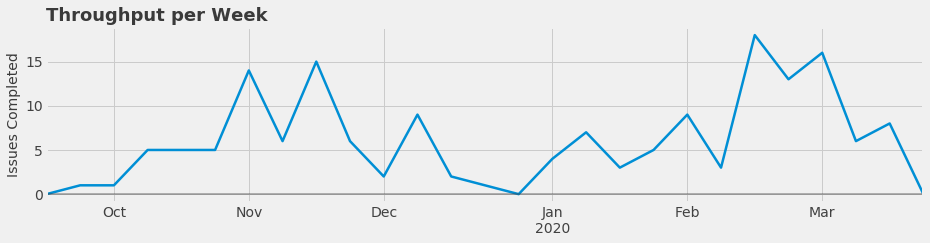

In [9]:
# split data into weeks
throughput = pd.crosstab(
    df_issues.done_fd, df_issues.issue_type, colnames=[None]
).reset_index()

# filter issues by types, only get the implementation stories
throughput["Throughput"] = (
    throughput.bug + throughput.story + throughput.techdebt
)

date_range = pd.date_range(start=throughput.done_fd.min(), end=throughput.done_fd.max())

throughput = (
    throughput.set_index("done_fd")
    .reindex(date_range)
    .fillna(0)
    .astype(int)
    .rename_axis("Date")
)

throughput_per_week = pd.DataFrame(
    throughput["Throughput"].resample("W-Mon").sum()
).reset_index()

# draw the diagram
ax = throughput_per_week.plot(
    x="Date", y="Throughput", linewidth=2.5, figsize=(14, 3), legend=None
)
ax.set_title(
    "Throughput per Week",
    loc="left",
    fontdict={"fontsize": 18, "fontweight": "semibold"},
)
ax.set_xlabel("")
ax.set_ylabel("Issues Completed")
ax.axhline(y=0, color=lightgrey, alpha=0.5)

<a id='mcarlo1'></a>
## Monte Carlo Simulation for certain amount of items
Based on the throughput data we simulate multiple times how many items can be completed in the given time span. Before we run the simulation we set the configuration values:

* Date range of data basis 
* Number of days to simulate (probably an iteration or release window)
* Number of simulations to run (Recommendation: >= 10000).

We plot the simulation results to get a brief overview of distribution of total items completed in the given timespan.

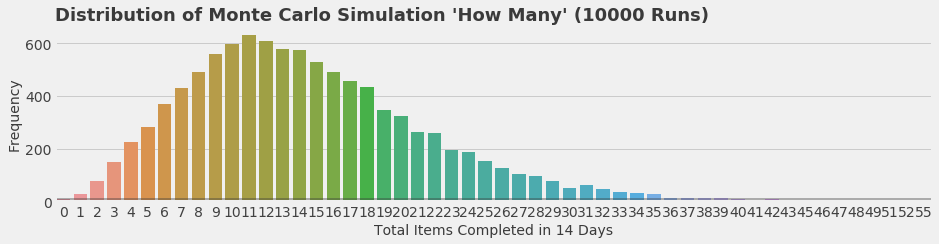

In [17]:
# NOTE: Please remember to set parameters!!
DATE_RANGE = 150
SIMULATION_DAYS = 14
SIMULATIONS = 10000

# get only requested amount of days of data & run simulation
dataset = throughput[["Throughput"]].tail(DATE_RANGE).reset_index(drop=True)
samples = [
    dataset.sample(n=SIMULATION_DAYS, replace=True).sum().Throughput
    for i in range(SIMULATIONS)
]
samples = pd.DataFrame(samples, columns=["Items"])
distribution = samples.groupby(["Items"]).size().reset_index(name="Frequency")

# plot the result
plt.figure(figsize=(14, 3))
ax = sns.barplot(x="Items", y="Frequency", data=distribution)
ax.set_title(
    f"Distribution of Monte Carlo Simulation 'How Many' ({SIMULATIONS} Runs)",
    loc="left",
    fontdict={"size": 18, "weight": "semibold"},
)
ax.set_xlabel(f"Total Items Completed in {SIMULATION_DAYS} Days")
ax.set_ylabel("Frequency")
ax.axhline(y=SIMULATIONS * 0.001, color=darkgrey, alpha=0.5)

## Analysis of the Probabilities of Occurrence
We determine the probability for each number of completed items by cumulating the frequency in the simulations. We plot the probability for each number of completed items and indicate the percentiles 70%, 85%, and 95%.

[Text(0, 0, '0'),
 Text(0, 0, '20'),
 Text(0, 0, '40'),
 Text(0, 0, '60'),
 Text(0, 0, '80'),
 Text(0, 0, '100%')]

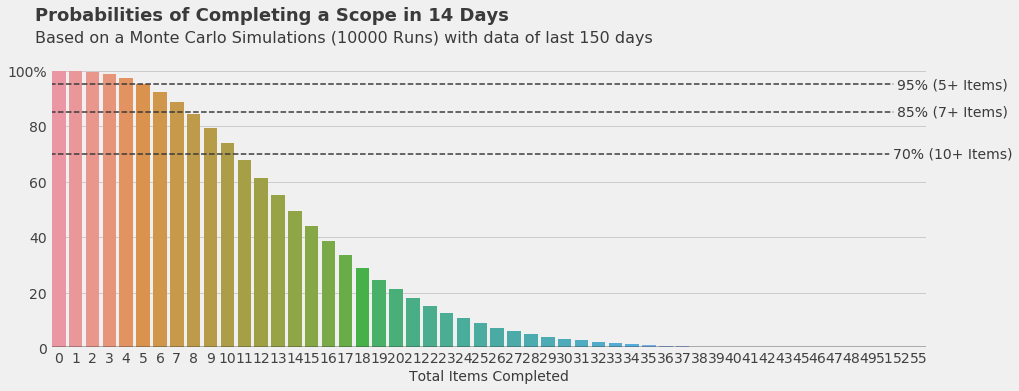

In [18]:
# run distribution
distribution = distribution.sort_index(ascending=False)
distribution["Probability"] = (
    100 * distribution.Frequency.cumsum() / distribution.Frequency.sum()
)

# plot data with percentiles 70%, 85%, and 95%
plt.figure(figsize=(14, 5))
ax = sns.barplot(x="Items", y="Probability", data=distribution)
ax.text(
    x=-1.4,
    y=118,
    s=f"Probabilities of Completing a Scope in {SIMULATION_DAYS} Days",
    fontsize=18,
    fontweight="semibold",
)
ax.text(
    x=-1.4,
    y=110,
    s=f"Based on a Monte Carlo Simulations ({SIMULATIONS} Runs) with data of last {DATE_RANGE} days",
    fontsize=16,
)
ax.set_ylabel("")
ax.set_xlabel("Total Items Completed")
ax.axhline(y=0.5, color=darkgrey, alpha=0.5)
ax.axhline(y=70, color=darkgrey, linestyle="--")
ax.axhline(y=85, color=darkgrey, linestyle="--")
ax.axhline(y=95, color=darkgrey, linestyle="--")
label_xpos = distribution["Items"].max() - 2
ax.text(
    y=70,
    x=label_xpos,
    s=f"70%% (%d+ Items)" % samples.Items.quantile(0.3),
    va="center",
    ha="center",
    backgroundcolor="#F0F0F0",
)
ax.text(
    y=85,
    x=label_xpos,
    s=f"85%% (%d+ Items)" % samples.Items.quantile(0.15),
    va="center",
    ha="center",
    backgroundcolor="#F0F0F0",
)
ax.text(
    y=95,
    x=label_xpos,
    s=f"95%% (%d+ Items)" % samples.Items.quantile(0.05),
    va="center",
    ha="center",
    backgroundcolor="#F0F0F0",
)
ax.set_yticklabels(labels=["0", "20", "40", "60", "80", "100%"])

<a id='mcarlo2'></a>
## Monte Carlo Simulation for time window
Based on the throughput data we simulate multiple times when the number of items will be completed. Before we run the simulation we set the configuration values:

* Date range of data basis
* Number of items to simulate.
* Start date of work
* Number of simulations to run (Recommendation: >= 10000).

We plot the simulation results to get a brief overview of distribution of completion dates.

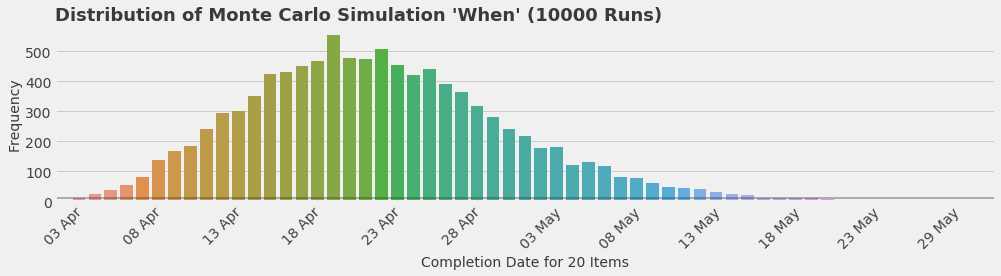

In [19]:
# NOTE: Please remember to set parameters!!
DATE_RANGE = 150
SIMULATION_ITEMS = 20
START_DATE = pd.to_datetime("2020-04-01")
SIMULATIONS = 10000


def simulate_days(data, scope):
    days = 0
    total = 0
    while total <= scope:
        total += dataset.sample(n=1).iloc[0].Throughput
        days += 1
    completion_date = START_DATE + pd.Timedelta(days, unit="d")
    return completion_date


# get only requested amount of days of data & run simulation
dataset = throughput[["Throughput"]].tail(DATE_RANGE).reset_index(drop=True)
samples = [simulate_days(dataset, SIMULATION_ITEMS) for i in range(SIMULATIONS)]
samples = pd.DataFrame(samples, columns=["Date"])
distribution = samples.groupby(["Date"]).size().reset_index(name="Frequency")

# plot the results
plt.figure(figsize=(15, 3))
ax = sns.barplot(x="Date", y="Frequency", data=distribution)
ax.set_title(
    f"Distribution of Monte Carlo Simulation 'When' ({SIMULATIONS} Runs)",
    loc="left",
    fontdict={"size": 18, "weight": "semibold"},
)
ax.set_xlabel(f"Completion Date for {SIMULATION_ITEMS} Items")
ax.set_ylabel("Frequency")
unique_dates = sorted(list(distribution["Date"].drop_duplicates()))
date_ticks = range(0, len(unique_dates), 5)
ax.set_xticks(date_ticks)
ax.set_xticklabels([unique_dates[i].strftime("%d %b") for i in date_ticks], rotation=45)
ax.axhline(y=SIMULATIONS * 0.001, color=darkgrey, alpha=0.5)

## Analysis of the Probabilities of Occurrence

We determine the probability for each number of completed items by cumulating the frequency in the simulations. We plot the probability for each number of completed items and indicate the percentiles 70%, 85%, and 95%.

[Text(0, 0, '03 Apr'),
 Text(0, 0, '08 Apr'),
 Text(0, 0, '13 Apr'),
 Text(0, 0, '18 Apr'),
 Text(0, 0, '23 Apr'),
 Text(0, 0, '28 Apr'),
 Text(0, 0, '03 May'),
 Text(0, 0, '08 May'),
 Text(0, 0, '13 May'),
 Text(0, 0, '18 May'),
 Text(0, 0, '23 May'),
 Text(0, 0, '29 May')]

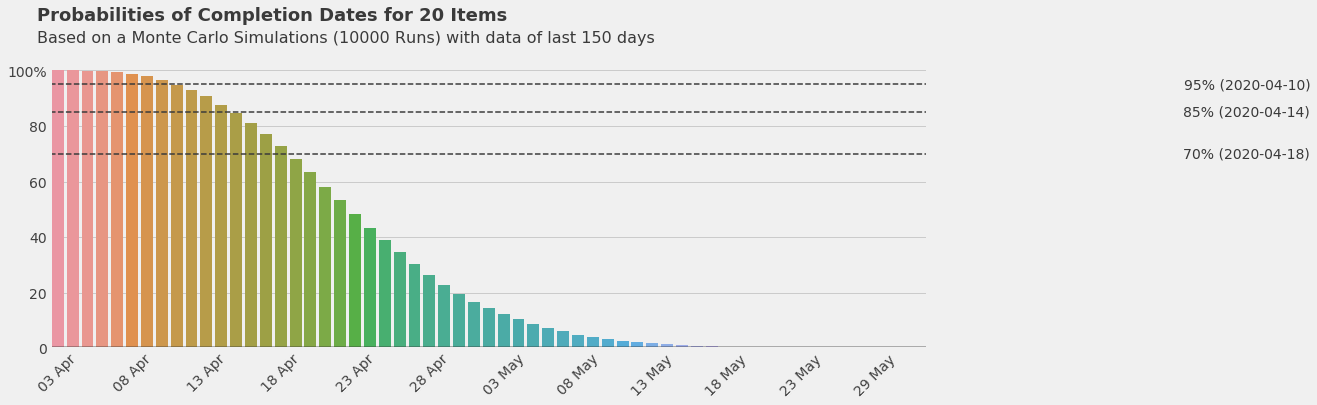

In [20]:
# run distribution
distribution = distribution.sort_index(ascending=False)
distribution["Probability"] = (
    100 * distribution.Frequency.cumsum() / distribution.Frequency.sum()
)

# plot data with percentiles 70%, 85%, and 95%
plt.figure(figsize=(14, 5))
ax = sns.barplot(x="Date", y="Probability", data=distribution)
ax.text(
    x=-1.4,
    y=118,
    s=f"Probabilities of Completion Dates for {SIMULATION_ITEMS} Items",
    fontsize=18,
    fontweight="semibold",
)
ax.text(
    x=-1.4,
    y=110,
    s=f"Based on a Monte Carlo Simulations ({SIMULATIONS} Runs) with data of last {DATE_RANGE} days",
    fontsize=16,
)
ax.set_ylabel("")
ax.set_xlabel("")
ax.axhline(y=0.5, color=darkgrey, alpha=0.5)
ax.axhline(y=70, color=darkgrey, linestyle="--")
ax.axhline(y=85, color=darkgrey, linestyle="--")
ax.axhline(y=95, color=darkgrey, linestyle="--")
label_xpos = distribution["Date"].max() - pd.Timedelta(30, unit="d")
ax.text(
    y=70,
    x=80,
    s=f"70% ({samples.Date.quantile(0.3).strftime('%Y-%m-%d')})",
    va="center",
    ha="center",
    backgroundcolor="#F0F0F0",
)
ax.text(
    y=85,
    x=80,
    s=f"85% ({samples.Date.quantile(0.15).strftime('%Y-%m-%d')})",
    va="center",
    ha="center",
    backgroundcolor="#F0F0F0",
)
ax.text(
    y=95,
    x=80,
    s=f"95% ({samples.Date.quantile(0.05).strftime('%Y-%m-%d')})",
    va="center",
    ha="center",
    backgroundcolor="#F0F0F0",
)
ax.set_yticklabels(labels=["0", "20", "40", "60", "80", "100%"])

unique_dates = sorted(list(distribution["Date"].drop_duplicates()))
date_ticks = range(0, len(unique_dates), 5)
ax.set_xticks(date_ticks)
ax.set_xticklabels([unique_dates[i].strftime("%d %b") for i in date_ticks], rotation=45)